# Prodigy InfoTech Data Science Internship Task 4
## Sentiment Analysis of Twitter tweets
We will be analyzing the sentiment of tweets present in the dataset.


## Importing Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re

## Importing Dataset

In [2]:
train_df = pd.read_csv("twitter_training.csv", names=["id", "topic", "label", "tweet"])
test_df = pd.read_csv("twitter_validation.csv", names=["id", "topic", "label", "tweet"])
print(train_df.shape)
print(test_df.shape)

(74682, 4)
(1000, 4)


In [3]:
train_df.head()

,id,topic,label,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
test_df.head()

,id,topic,label,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


### Checking for Null values

In [5]:
# check for missing values
train_df.isnull().sum()

id         0
topic      0
label      0
tweet    686
dtype: int64

Since tweet is an important feature, we will be removing the rows which have null values in the tweet column.

In [6]:
# removing missing values
train_df.dropna(inplace=True)
train_df.isnull().sum()

id       0
topic    0
label    0
tweet    0
dtype: int64

In [7]:
test_df.isnull().sum()

id       0
topic    0
label    0
tweet    0
dtype: int64

No null values are present in the dataset.

### Lets check the Distribution of the label column.

In [8]:
(train_df.groupby('label').count())

,id,topic,tweet
label,,,
Irrelevant,12875,12875,12875
Negative,22358,22358,22358
Neutral,18108,18108,18108
Positive,20655,20655,20655


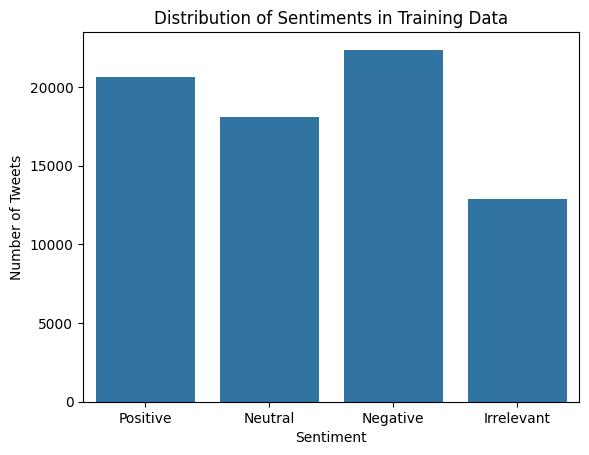

In [9]:
sns.countplot(x="label", data=train_df)
plt.title("Distribution of Sentiments in Training Data")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

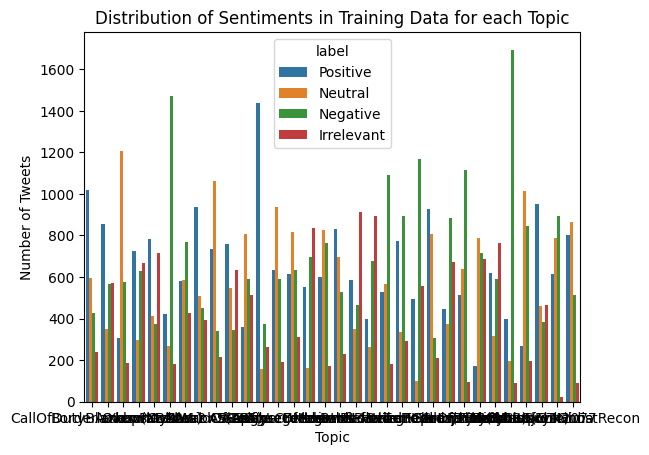

In [10]:
# Showing the Various distribution of sentiments in the training data for each topic

sns.countplot(x="topic", hue="label", data=train_df)
plt.title("Distribution of Sentiments in Training Data for each Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Tweets")
plt.show()


## Converting the columns to numerical values

### Label column

In [11]:
train_df['label'].value_counts()

label
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [12]:
labels_dict = {'Negative': 0, 'Neutral': 1, 'Positive': 2, "Irrelevant": 3}
train_df['label'] = train_df['label'].map(labels_dict)
test_df['label'] = test_df['label'].map(labels_dict)
train_df.head()

,id,topic,label,tweet
0,2401,Borderlands,2,im getting on borderlands and i will murder yo...
1,2401,Borderlands,2,I am coming to the borders and I will kill you...
2,2401,Borderlands,2,im getting on borderlands and i will kill you ...
3,2401,Borderlands,2,im coming on borderlands and i will murder you...
4,2401,Borderlands,2,im getting on borderlands 2 and i will murder ...


### Topic column

In [13]:
train_df['topic'].value_counts()

topic
MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283
Borderlands                 

In [14]:
# Using LabelEncoder to convert categorical values to numerical values

encoder = LabelEncoder()
train_df['topic'] = encoder.fit_transform(train_df['topic'])
train_df.head()

,id,topic,label,tweet
0,2401,4,2,im getting on borderlands and i will murder yo...
1,2401,4,2,I am coming to the borders and I will kill you...
2,2401,4,2,im getting on borderlands and i will kill you ...
3,2401,4,2,im coming on borderlands and i will murder you...
4,2401,4,2,im getting on borderlands 2 and i will murder ...


### Tweet column

In [15]:
# Removing all punctuations, special characters and numbers from the tweets
train_df['tweet'] = train_df['tweet'].str.replace("[^a-zA-Z]", " ")
test_df['tweet'] = test_df['tweet'].str.replace("[^a-zA-Z]", " ")
# Converting all the tweets to lower case
train_df['tweet'] = train_df['tweet'].str.lower()
test_df['tweet'] = test_df['tweet'].str.lower()

In [16]:
# Using TfidfVectorizer to convert text into tokens/features
vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
X_train_tweet = vectorizer.fit_transform(train_df["tweet"])
X_test_tweet = vectorizer.transform(test_df["tweet"])


### Checking for numerical values

In [17]:
train_df.head()

,id,topic,label,tweet
0,2401,4,2,im getting on borderlands and i will murder yo...
1,2401,4,2,i am coming to the borders and i will kill you...
2,2401,4,2,im getting on borderlands and i will kill you ...
3,2401,4,2,im coming on borderlands and i will murder you...
4,2401,4,2,im getting on borderlands 2 and i will murder ...


## Training the model

In [18]:
"""
# Training the model using RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_tweet, train_df["label"])
#"""

# Output : Training Accuracy: 0.7081463862911509

'\n# Training the model using RandomForestClassifier\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_tweet, train_df["label"])\n#'

### Saving the Model

In [19]:
'''
# Saving the model
pickle.dump(model, open("model.pkl", "wb"))

'''

'\n# Saving the model\npickle.dump(model, open("model.pkl", "wb"))\n\n'

In [20]:
# Opening the saved model
model = pickle.load(open("model.pkl", "rb"))

# Predicting the labels for the test data
y_train_pred = model.predict(X_train_tweet)
y_test_pred = model.predict(X_test_tweet)

# Calculating the accuracy of the model
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(train_df["label"], y_train_pred)
test_acc = accuracy_score(test_df["label"], y_test_pred)
print("Training Accuracy:", train_acc)
print("Testing Accuracy:", test_acc)

Training Accuracy: 0.7081463862911509
Testing Accuracy: 0.722


In [21]:
model.score(X_train_tweet, train_df["label"])

0.7081463862911509

## Predicting the sentiment of the tweets

In [22]:
def predict_sentiment(tweet):
    tweet = tweet.lower()
    tweet = re.sub("[^a-zA-Z]", " ", tweet)
    tweet = vectorizer.transform([tweet])
    prediction = model.predict(tweet)
    if prediction == 0:
        return "Negative"
    elif prediction == 1:
        return "Neutral"
    elif prediction == 2:
        return "Positive"
    else:
        return "Irrelevant"


In [23]:
list_of_tweets = ["This is such a Bad Game", "I love this game", "I hate this game", "I don't know what to say"]
for tweet in list_of_tweets:
    print(tweet, ":", predict_sentiment(tweet))

This is such a Bad Game : Negative
I love this game : Positive
I hate this game : Negative
I don't know what to say : Irrelevant


## Conclusion

In this notebook, we performed Twitter sentiment analysis using a dataset of tweets. We started by importing the necessary modules and loading the dataset. We then explored the data, checked for missing values, and visualized the distribution of sentiments in the training data.

Next, we preprocessed the data by converting the categorical columns to numerical values and cleaning the tweet text by removing punctuations, special characters, and numbers. We used the TfidfVectorizer to convert the text into numerical features.

After preprocessing, we trained a RandomForestClassifier model on the training data and evaluated its performance on the testing data. We achieved a training accuracy of 0.708 and a testing accuracy of 0.72.

Finally, we saved the trained model and created a function to predict the sentiment of new tweets. We tested the function on a list of example tweets and obtained the predicted sentiment for each tweet.

Overall, this notebook provides a comprehensive workflow for performing Twitter sentiment analysis. The trained model can be used to analyze the sentiment of new tweets and gain insights from social media data.
